# Importing Libaries

In [1]:
from data_import import api_request
from data_cleaning import data_cleaner

import numpy as np
import pandas as pd

import json
from time import sleep
from random import randint

import re
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

In [2]:
# importing ratings, movies and imdb links
ratings_df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")
links_df = pd.read_csv("links.csv")

In [0]:
ratings_df.head()

In [0]:
# merging imdb links with movies
movies_df = pd.merge(movies_df, links_df, left_on = "movieId", right_on = "movieId").drop(columns = ["tmdbId"])
# reformatting imdb ids for api requests
movies_df['imdbId'] = movies_df['imdbId'].map(lambda x: 'tt{0:07d}'.format(x))

In [0]:
movies_df.head()

In [0]:
# storing imdb ids
imdb_ids = list(movies_df['imdbId'])
# storing api key
api_key = json.load(open(".secret/imdb_api_key.json"))['api_key']

In [0]:
# collecting genres, plots, directors and actors from imdb website
api_request(imdb_ids, api_key, 'api_requests.csv', 0.1)

In [0]:
# importing requests
requests_df = pd.read_csv('api_requests.csv').drop(columns = ['Unnamed: 0']).drop_duplicates()

In [0]:
# merging requests with movies
movies_df = pd.merge(movies_df, requests_df, left_on = 'imdbId', right_on = 'imdb_id').drop(columns = ['genres_x', 'imdbId', 'imdb_id'])
# renaming columns for movies dataframe
movies_df['genres'] = movies_df['genres_y']
movies_df['ageRating'] = movies_df['age_rating']
movies_df.drop(columns = ['genres_y', 'age_rating'], inplace = True)

In [0]:
movies_df.to_csv('movies_full.csv')

In [0]:
movies_df.head()

# Data Cleaning

In [2]:
data_cleaner("movies_full.csv", "ratings.csv")

files cleaned


# EDA

In [2]:
ratings_df = pd.read_csv('ratings_cleaned_and_reduced.csv')
movies_df = pd.read_csv('movies_cleaned_and_reduced.csv').drop(columns = ['Unnamed: 0'])

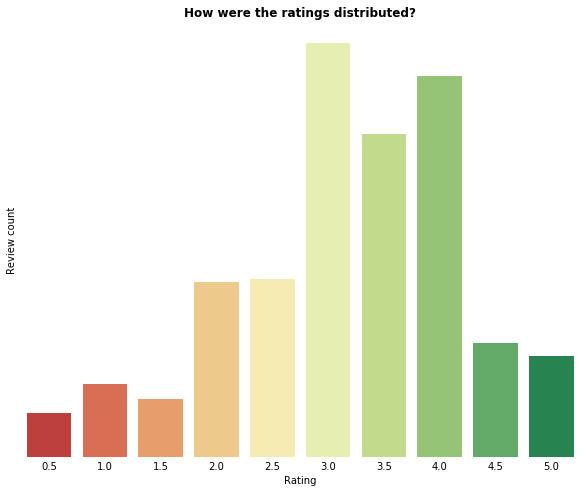

In [152]:
rating_counts = pd.DataFrame(ratings_df['rating'].value_counts()).reset_index()
rating_counts.columns = ['rating', 'review_count']
rating_counts = rating_counts.sort_values('rating', ascending = False)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'rating', y = 'review_count', data = rating_counts, palette = 'RdYlGn')
ax.set_xticklabels(np.arange(0.5,5.5,0.5))
ax.set_yticks([])
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('How were the ratings distributed?', fontweight = 'bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Review count');

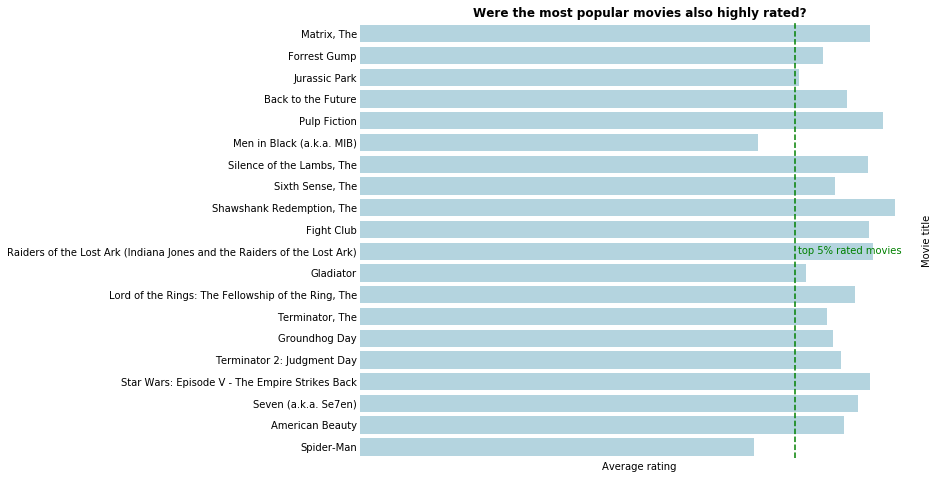

In [153]:
top_movies = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
top_movies.columns = ['movieId', 'review_count', 'average_rating']
top_movies = pd.merge(top_movies, movies_df, left_on = 'movieId', right_on = 'movieId')[['title', 'review_count', 'average_rating']]
top_movies_sorted = top_movies.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'title', data = top_movies_sorted.head(20), orient = 'h', color = 'lightblue')
top_5_percent_line = top_movies_sorted['average_rating'].quantile(0.95)
ax.axvline(top_5_percent_line, color = 'green', ls = '--')
ax.text(top_5_percent_line + 0.02, 10.1,'top 5% rated movies', color = 'green')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most popular movies also highly rated?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('Movie title');

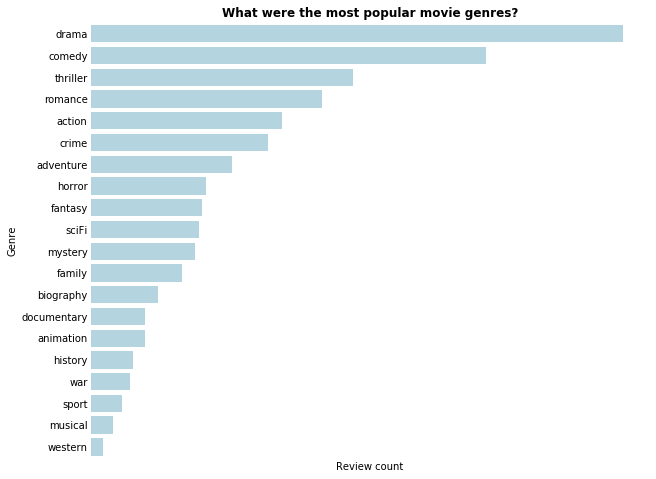

In [154]:
genre_counts = pd.DataFrame(movies_df.drop(columns = ['movieId', 'title', 'director', 'actors', 'plot']).sum()).reset_index()
genre_counts.columns = ['genre', 'review_count']
sorted_genre_counts = genre_counts.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'review_count', y = 'genre', data = sorted_genre_counts, orient = 'h', color = 'lightblue')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('What were the most popular movie genres?', fontweight = 'bold')
ax.set_xlabel('Review count')
ax.set_ylabel('Genre');

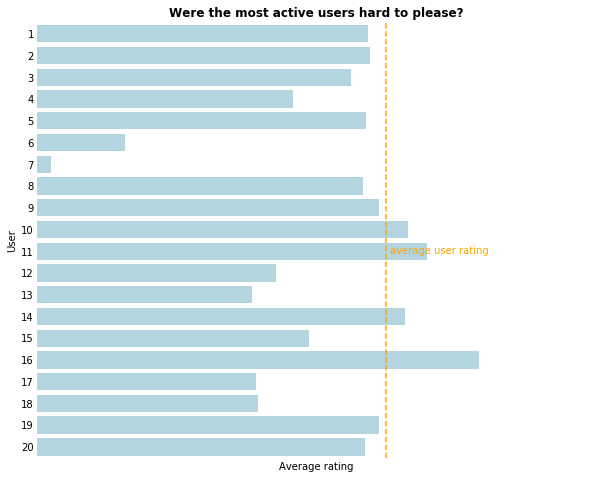

In [155]:
top_users = ratings_df.groupby('userId')['rating'].agg(['count', 'mean']).reset_index()
top_users.columns = ['userId', 'review_count', 'average_rating']
top_users_sorted = top_users.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'userId', data = top_users_sorted.head(20), orient = 'h', color = 'lightblue')
mean_line = top_users_sorted['average_rating'].mean()
ax.axvline(mean_line, color = 'orange', ls = '--')
ax.text(mean_line + 0.02, 10.1,'average user rating', color = 'orange')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.set_yticklabels(range(1,21))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most active users hard to please?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('User');

# Modelling